<a href="https://colab.research.google.com/github/mdunlop2/barrier-option-pricer/blob/master/colab_pricer_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Imports

In [0]:
# General Imports
import math as m
import numpy as np
import matplotlib.pyplot as plt
import time

import pandas as pd

%load_ext Cython

try:
  import pytorch
except:
  !pip install -q torch==1.1.0 torchvision==0.3.0
  import torch
  print(torch.__version__)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
     |████████████████████████████████| 676.9MB 24kB/s 
1.0.0


## Strongly Typed Payoff

In [0]:
 %%cython

# Barrier Option Payoff Code
# 5 April 2019
# Matthew Dunlop
cimport numpy as np
import numpy as np

cpdef np.ndarray[double] typed_payoff(np.ndarray S_val,
                                       np.ndarray counter1,
                                       np.ndarray counter2,
                                      double K):
#   assert (S_val.dtype == np.float
#          and counter1.dtype == np.int
#          and counter2.dtype == np.int)
  cdef Py_ssize_t i, n = len(counter1)
  assert (len(S_val) == len(counter2) == n)
  cdef np.ndarray[double] payoff = np.empty(n)
  for i in range(n):
    if (S_val[i,-1] > K) and (counter2[i] >= 150):
        payoff[i] = S_val[i,-1] - K + 20
    elif (S_val[i,-1] > K) and (counter1[i] >= 100) and (counter2[i] < 150):
        payoff[i] = S_val[i,-1] - K
    elif (S_val[i,-1] > K) and (counter1[i] < 100):
        payoff[i]= 10
    else:
        payoff[i] = 0
  return payoff
 

## Monte Carlo Functions

### Pricing Functions

In [0]:
def Crude_Monte_Carlo(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  payoff = np.zeros((nr,1))
  
  # instantiate result, payoff, and random matrices
  S_val = np.zeros((nr,n+1))
  rand = np.random.randn(nr,n)
  

  # instantiate counter matrices
  counter1 = np.zeros((nr,1))
  counter2 = np.zeros((nr,1))
  
  # simulate stock price via MC (and increment counters)
  S_val[:,0] = S
  for i in range(nr):
      for j in range(1,n+1):
          S_val[i,j] = S_val[i,j-1] * m.exp(nu*dt + sigma * dt **.5 * rand[i,j-1])

          if S_val[i,j] > H2:
              counter1[i] += 1
              counter2[i] += 1
          elif S_val[i,j] > H1:
              counter1[i] += 1

  # compute payoff of each sim
  for i in range(nr):
      if (S_val[i,-1] > K) and (counter2[i] >= 150):
          payoff[i] = S_val[i,-1] - K + 20
      elif (S_val[i,-1] > K) and (counter1[i] >= 100) and (counter2[i] < 150):
          payoff[i] = S_val[i,-1] - K
      elif (S_val[i,-1] > K) and (counter1[i] < 100):
          payoff[i]= 10
      else:
          payoff[i] = 0
  return S_val, payoff, counter1, counter2

In [0]:
def AVT_Monte_Carlo(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  payoff = np.zeros(( int(nr/2), 1))
  
  # instantiate result, payoff, and random matrices
  S_val = np.zeros((nr,n+1))
  rand = np.random.randn(int(nr/2),n)
  
  # instantiate counter matrices
  counter1 = np.zeros((nr,1))
  counter2 = np.zeros((nr,1))
  
  # simulate stock price via MC (and increment counters)
  S_val[:,0] = S
  for i in range(0, nr, 2):
      # taking two steps at a time in the share value dataframe
      for j in range(1,n+1):
          S_val[i,j] = S_val[i,j-1] * m.exp(nu*dt + sigma * dt**0.5 * rand[int(i/2),j-1])
          S_val[i+1,j] = S_val[i+1,j-1] * m.exp(nu*dt - sigma * dt**0.5 * rand[int(i/2),j-1])

          if S_val[i,j] > H2:
              counter1[i] += 1
              counter2[i] += 1
          elif S_val[i,j] > H1:
              counter1[i] += 1
          # repeat for the antithetic row:
          if S_val[i+1,j] > H2:
              counter1[i+1] += 1 # counter for the antithetic row
              counter2[i+1] += 1
          elif S_val[i+1,j] > H1:
              counter1[i+1] += 1

  # compute payoff of each sim
  for i in range(0, nr, 2):
      # Want to take average of positive and negative paths to save memory
      if (S_val[i,-1] > K) and (counter2[i] >= 150):
          # payoff[i] = S_val[i,-1] - K + 20
          p = S_val[i,-1] - K + 20
      elif (S_val[i,-1] > K) and (counter1[i] >= 100) and (counter2[i] < 150):
          # payoff[i] = S_val[i,-1] - K
          p = S_val[i,-1] - K
      elif (S_val[i,-1] > K) and (counter1[i] < 100):
          # payoff[i]= 10
          p = 10
      else:
          # payoff[i] = 0 # not necessary b/c all were initialized to 0
          p = 0

          # now payoff for the negative path:
      if (S_val[i+1,-1] > K) and (counter2[i+1] >= 150):
          # payoff[i] = S_val[i,-1] - K + 20
          n = S_val[i+1,-1] - K + 20
      elif (S_val[i+1,-1] > K) and (counter1[i+1] >= 100) and (counter2[i+1] < 150):
          # payoff[i] = S_val[i,-1] - K
          n = S_val[i+1,-1] - K
      elif (S_val[i+1,-1] > K) and (counter1[i+1] < 100):
          # payoff[i]= 10
          n = 10
      else:
          n = 0
      payoff[int(i/2)] = 0.5*p + 0.5*n
  return S_val, payoff, counter1, counter2

In [0]:
def Crude_Monte_Carlo_NPO(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  ~Numpy Optimized Option~
  Remove the For Loops in Crude_Monte_Carlo()
  
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  rand = np.random.randn(nr,n)
  # simulate stock price via MC (and increment counters)
  S_val = S * np.cumprod(np.exp((nu)*dt+sigma*np.sqrt(dt)*rand), axis=1)
  counter1 = (S_val >= H1).sum(axis = 1)
  counter2 = (S_val >= H2).sum(axis = 1)
  # This is a 69.45x increase already! On a single thread!
  # compute payoff of each sim
  payoff = typed_payoff(S_val, counter1, counter2, K)
  # This is a 4 ms decrease or 10% improvement on 41ms
  # Using pre compiled code
  return S_val, payoff, counter1, counter2

In [0]:
def AVT_Monte_Carlo_NPO(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  ~Numpy Optimized Option Anthithetic Variates Technique~
  Remove the For Loops in Crude_Monte_Carlo()
  
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  # only need half of the random matrix:
  rand = np.random.randn(int(nr/2),n)
  # simulate stock price via MC (and increment counters)
  # need positive and negative
  S_val_p = S * np.cumprod(np.exp((nu)*dt+sigma*np.sqrt(dt)*rand), axis=1)
  S_val_n = S * np.cumprod(np.exp((nu)*dt-sigma*np.sqrt(dt)*rand), axis=1)
  # This is justified as we take the mean of payoff anyway, ie. 0.5*positive_path + 0.5*negative_path
  S_val = np.append(S_val_p, S_val_n, axis = 0)
  counter1 = (S_val >= H1).sum(axis = 1)
  counter2 = (S_val >= H2).sum(axis = 1)
  # compute payoff of each sim
  payoff_p = typed_payoff(S_val[:int(nr/2),], counter1[:int(nr/2),], counter2[:int(nr/2),], K)
  payoff_n = typed_payoff(S_val[int(nr/2):,], counter1[int(nr/2):,], counter2[int(nr/2):,], K)
  payoff = 0.5*payoff_p + 0.5*payoff_n
  # Using pre compiled code
  return S_val, payoff, counter1, counter2


In [0]:
def Crude_Monte_Carlo_Torch(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  ~Pytorch~
  Remove the For Loops in Crude_Monte_Carlo()
  
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  _r = torch.tensor([float(r)], requires_grad = True)
  _T = torch.tensor([float(T)], requires_grad = True)
  _sigma = torch.tensor([float(sigma)], requires_grad = True)
  _n = torch.tensor([float(n)], requires_grad = True)
  _nr = torch.tensor([float(nr)], requires_grad = True)
  
  rand = torch.FloatTensor(nr, n).normal_(mean = 0, std = 1)

  # for exponent (risk-neutral)
  nu = _r - .5 * _sigma ** 2
  dt = _T / _n
  
  # simulate stock price via MC (and increment counters)
  S_val = S * torch.cumprod(torch.exp((nu)*dt+sigma*torch.sqrt(dt)*rand), dim=1)
  # (S_val >= H1).sum(axis = 1)
  counter1 = torch.sum(S_val >= H1, 1).detach().numpy()
  counter2 = torch.sum(S_val >= H2, 1).detach().numpy()
  #
  del rand
  S_val = S_val.detach().numpy()
  # return S_val to numpy
  payoff = typed_payoff(S_val, counter1, counter2, K)
  # This is a 4 ms decrease or 10% improvement on 41ms
  # Using pre compiled code
  return S_val, payoff, counter1, counter2

In [0]:
def AVT_Monte_Carlo_Torch(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  ~Pytorch~
  
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  _r = torch.tensor([float(r)], requires_grad = True)
  _T = torch.tensor([float(T)], requires_grad = True)
  _sigma = torch.tensor([float(sigma)], requires_grad = True)
  _n = torch.tensor([float(n)], requires_grad = True)
  _nr = torch.tensor([float(nr)], requires_grad = True)
  
  # for exponent (risk-neutral)
  nu = _r - .5 * _sigma ** 2
  dt = _T / _n
  
  rand = torch.FloatTensor((int(nr/2)), n).normal_(mean = 0, std = 1)
                                            
  S_val_p = S * torch.cumprod(torch.exp((nu)*dt+sigma*torch.sqrt(dt)*rand), dim=1)
  S_val_n = S * torch.cumprod(torch.exp((nu)*dt-sigma*torch.sqrt(dt)*rand), dim=1)
  S_val = torch.cat([S_val_p, S_val_n], dim=0)
  counter1 = torch.sum(S_val >= H1, 1).detach().numpy()
  counter2 = torch.sum(S_val >= H2, 1).detach().numpy()
  #
  del rand
  S_val = S_val.detach().numpy()
  # return S_val to numpy
  payoff_p = typed_payoff(S_val[:int(nr/2),], counter1[:int(nr/2),], counter2[:int(nr/2),], K)
  payoff_n = typed_payoff(S_val[int(nr/2):,], counter1[int(nr/2):,], counter2[int(nr/2):,], K)
  payoff = 0.5*payoff_p + 0.5*payoff_n
  # This is a 4 ms decrease or 10% improvement on 41ms
  # Using pre compiled code
  return S_val, payoff, counter1, counter2



In [0]:
def Crude_Monte_Carlo_Torch_GPU(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  ~Pytorch~
  Remove the For Loops in Crude_Monte_Carlo()
  
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  _r = torch.tensor([float(r)], requires_grad = True, device = 'cuda')
  _T = torch.tensor([float(T)], requires_grad = True, device = 'cuda')
  _sigma = torch.tensor([float(sigma)], requires_grad = True, device = 'cuda')
  _n = torch.tensor([float(n)], requires_grad = True, device = 'cuda')
  _nr = torch.tensor([float(nr)], requires_grad = True, device = 'cuda')
  
  
  rand = torch.cuda.FloatTensor(nr, n).normal_(mean = 0, std = 1)

  # for exponent (risk-neutral)
  nu = _r - .5 * _sigma ** 2
  dt = _T / _n
  
  # simulate stock price via MC (and increment counters)
  S_val = S * torch.cumprod(torch.exp((nu)*dt+sigma*torch.sqrt(dt)*rand), dim=1)
  # (S_val >= H1).sum(axis = 1)
  counter1 = torch.sum(S_val >= H1, 1).cpu().detach().numpy()
  counter2 = torch.sum(S_val >= H2, 1).cpu().detach().numpy()
  #
  del rand
  S_val = S_val.cpu().detach().numpy()
  # return S_val to numpy
  payoff = typed_payoff(S_val, counter1, counter2, K)
  # This is a 4 ms decrease or 10% improvement on 41ms
  # Using pre compiled code
  return S_val, payoff, counter1, counter2

In [0]:
def AVT_Monte_Carlo_Torch_GPU(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                     nu = 1, dt=1):
  '''
  ~Pytorch~
  Remove the For Loops in Crude_Monte_Carlo()
  
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  #####################################################
  OUTPUTS:
  S_val    :
  payoff   :
  counter1 :
  counter2 :
  
  '''
  _r = torch.tensor([float(r)], requires_grad = True, device = 'cuda')
  _T = torch.tensor([float(T)], requires_grad = True, device = 'cuda')
  _sigma = torch.tensor([float(sigma)], requires_grad = True, device = 'cuda')
  _n = torch.tensor([float(n)], requires_grad = True, device = 'cuda')
  _nr = torch.tensor([float(nr)], requires_grad = True, device = 'cuda')
  
  
  rand = torch.cuda.FloatTensor((int(nr/2)), n).normal_(mean = 0, std = 1)
  
  # for exponent (risk-neutral)
  nu = _r - .5 * _sigma ** 2
  dt = _T / _n
  
  # simulate stock price via MC (and increment counters)
  S_val_p = S * torch.cumprod(torch.exp((nu)*dt+sigma*torch.sqrt(dt)*rand), dim=1)
  S_val_n = S * torch.cumprod(torch.exp((nu)*dt-sigma*torch.sqrt(dt)*rand), dim=1)
  S_val = torch.cat([S_val_p, S_val_n], dim=0)
  # (S_val >= H1).sum(axis = 1)
  counter1 = torch.sum(S_val >= H1, 1).cpu().detach().numpy()
  counter2 = torch.sum(S_val >= H2, 1).cpu().detach().numpy()
  # 
  S_val = S_val.cpu().detach().numpy()
  del rand
  # return S_val to numpy
  payoff_p = typed_payoff(S_val[:int(nr/2),], counter1[:int(nr/2),], counter2[:int(nr/2),], K)
  payoff_n = typed_payoff(S_val[int(nr/2):,], counter1[int(nr/2):,], counter2[int(nr/2):,], K)
  payoff = 0.5*payoff_p + 0.5*payoff_n
  return S_val, payoff, counter1, counter2

### Master Function

In [0]:
def Barrier_Option_Pricer(S = 60, K = 50, H1 = 65, H2 = 85, r = .05, T = 1,
                          sigma = .3, n = 260, nr = 4000,
                          plot = False, Var_red = 0, pr = 0,
                         ret = 0):
  '''
  #####################################################
  Helper Function for interpreting user preferences for
  Plotting and Variance Reduction.
  
  Intended for simplifying process of running the
  pricer for different numbers of simulations etc
  #####################################################
  INPUTS:
  S, K, H1, H2, r, T, sigma, n, nr have usual meanings
  
  plot   : Whether the function plots or not # not implemented as of 4-April
  Var_red: Which Variance Reduction Technique to use:
            = 0: Crude Monte Carlo Pricer used
            = 1: Antithetic Variates Technique used
  
  '''
  # for exponent (risk-neutral)
  nu = r - .5 * sigma ** 2
  dt = T / n
  
  # Payoff matrix is dependent on the choice
  # of variance reduction technique
  
  if Var_red == 0:
      S_val, payoff, counter1, counter2 = Crude_Monte_Carlo(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
      
  elif Var_red == 1:
      S_val, payoff, counter1, counter2 = AVT_Monte_Carlo(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
  elif Var_red == 2:
      S_val, payoff, counter1, counter2 = Crude_Monte_Carlo_NPO(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
  elif Var_red == 3:
      S_val, payoff, counter1, counter2 = AVT_Monte_Carlo_NPO(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
  elif Var_red == 4:
      S_val, payoff, counter1, counter2 = Crude_Monte_Carlo_Torch(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
  elif Var_red == 5:
      S_val, payoff, counter1, counter2 = AVT_Monte_Carlo_Torch(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
  elif Var_red == 6:
      '''
      Warning: Must Have CUDA device available that supports Pytorch 1.0 !!!
      '''
      S_val, payoff, counter1, counter2 = Crude_Monte_Carlo_Torch_GPU(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
  elif Var_red == 7:
      '''
      Warning: Must Have CUDA device available that supports Pytorch 1.0 !!!
      '''
      S_val, payoff, counter1, counter2 = AVT_Monte_Carlo_Torch_GPU(S = S, K = K, H1 = H1, H2 = H2, r = r, T = T,
                          sigma = sigma, n = n, nr = nr,
                     nu = nu, dt=dt)
  
  PDisc = m.exp(-r*T)* payoff

  # mean & std for price
  price = PDisc.mean()
  p_std = np.std(PDisc)

  # mean & std for counters
  ave1 = counter1.mean()
  std1 = np.std(counter1)

  ave2 = counter2.mean()
  std2 = np.std(counter2)
  
  # to save GPU RAM
  del S_val, counter1, counter2
  
  if pr == 1:
    print("Counter1: \t Ave = {} \t Std Dev = {}".format(round(ave1,10),round(std1,10)))
    print("Counter2: \t Ave = {} \t Std Dev = {}\n".format(round(ave2,10),round(std2,10)))

    print("Price: \t Ave = ${} \t Std Dev = ${}".format(round(price,10),round(p_std,10)))
  if ret == 1:
    return ave1, std1, ave2, std2, price, p_std

## Demo

In [0]:
start = time.time()
Barrier_Option_Pricer(Var_red = 7, nr = 1000000, pr =1)
print("Time taken: {}".format(time.time()-start))

Counter1: 	 Ave = 84.519872 	 Std Dev = 85.0980926996
Counter2: 	 Ave = 14.023635 	 Std Dev = 36.2855137264

Price: 	 Ave = $14.5478898772 	 Std Dev = $7.8396019724
Time taken: 10.89088225364685


# Benchmarking

## Compare Each Method

In [0]:
# number of steps to compare, N
N = 3
# generate results for 1000 to 100000 paths
paths = np.linspace(1, 10, N, endpoint=True)
paths = 1000*np.around(paths **2)
methods = [0,1,2,3,4,5,6,7]
import time
start = time.time()

results = np.zeros((len(paths), len(methods)))
for path in range(len(paths)):
  for method in range(len(methods)):
    start = time.time()
    Barrier_Option_Pricer(Var_red = methods[method], nr = int(round(paths[path])))
    results[path,method] = time.time() - start

## Plots

In [0]:
results_df.describe()

,0,1,2,3,4,5,6,7
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,30.727913,33.386063,0.873765,0.679175,0.569453,0.544603,0.252393,0.247894
std,35.777369,38.771566,1.009532,0.779033,0.651278,0.614972,0.290914,0.282044
min,0.808870,0.855177,0.024587,0.013984,0.018236,0.012323,0.008400,0.007128
25%,10.912652,11.934741,0.315665,0.250659,0.210129,0.208003,0.091417,0.092739
50%,21.016433,23.014306,0.606743,0.487334,0.402021,0.403683,0.174435,0.178349
75%,45.687434,49.651506,1.298355,1.011770,0.845061,0.810743,0.374389,0.368277
max,70.358435,76.288706,1.989966,1.536206,1.288100,1.217804,0.574343,0.558206


### Full Comparison

Text(0.5, 0, 'Number of Paths Simulated')

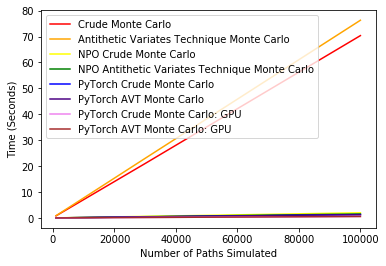

In [0]:
paths = np.linspace(1, 10, N, endpoint=True)
paths = 1000*np.around(paths **2)

results_df = pd.DataFrame(data = results, index = (paths), columns = methods)

methods = results_df.columns

labels = ['Crude Monte Carlo',
         'Antithetic Variates Technique Monte Carlo',
         'NPO Crude Monte Carlo',
         'NPO Antithetic Variates Technique Monte Carlo',
         'PyTorch Crude Monte Carlo',
         'PyTorch AVT Monte Carlo',
         'PyTorch Crude Monte Carlo: GPU',
         'PyTorch AVT Monte Carlo: GPU']



colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'brown']

for method,c, label in zip(methods, colors, labels):
  plt.plot(paths, results_df[method], color = c, label = label)
plt.legend()
plt.ylabel('Time (Seconds)')
plt.xlabel('Number of Paths Simulated')

### Compare Torch and Numpy Optimised only 

Text(0.5, 0, 'Number of Paths Simulated')

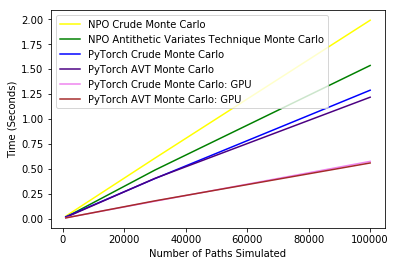

In [0]:
for method,c, label in zip(methods[2:], colors[2:], labels[2:]):
  plt.plot(paths, results_df[method], color = c, label = label)
plt.legend()
plt.ylabel('Time (Seconds)')
plt.xlabel('Number of Paths Simulated')

# Absolute Minimum Error answer

## To combine estimates from multiple runs

In [0]:
# store the results in an array
start = time.time()
torch.cuda.empty_cache()
iters = 100
paths = 1000000
best_estimate_arr = np.zeros((iters, 6)) #6 columns of data
cols = ['ave1', 'std1', 'ave2', 'std2', 'price', 'p_std']
for i in range(iters):
  best_estimate_arr[i] = Barrier_Option_Pricer(ret = 1, Var_red = 7, nr = paths, pr =0)
  torch.cuda.empty_cache()
best_estimate_df = pd.DataFrame(data = best_estimate_arr, index = list(range(iters)), columns = cols)
best_estimate_df.to_csv('minimum_error.csv')
print("Time elapsed: {}".format(time.time()-start))

Time elapsed: 596.7026634216309


In [0]:
print("Best estimate of price: {}\nAfter {} paths simulated".format(best_estimate_df['price'].mean(), iters*paths))
best_estimate_df.describe()

Best estimate of price: 14.548767451794056
After 100000000 paths simulated


,ave1,std1,ave2,std2,price,p_std
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,84.503787,85.086907,14.011870,36.273673,14.548767,7.857207
std,0.036032,0.041725,0.036232,0.063989,0.011520,0.018144
min,84.401734,84.993434,13.897128,36.073781,14.516564,7.806746
25%,84.482158,85.054380,13.986759,36.223772,14.540977,7.844174
50%,84.502964,85.088126,14.012097,36.283290,14.549025,7.855800
75%,84.529206,85.118546,14.040595,36.325549,14.555588,7.872207
max,84.588001,85.191682,14.089767,36.412102,14.576226,7.894280


(array([ 1.28806039,  5.50353075, 18.73542384, 30.91344934, 33.48957012,
        19.32090584,  6.20610915,  1.28806039,  0.2341928 ,  0.1170964 ]),
 array([14.51539612, 14.5239361 , 14.53247607, 14.54101604, 14.54955601,
        14.55809598, 14.56663596, 14.57517593, 14.5837159 , 14.59225587,
        14.60079585]),
 <a list of 10 Patch objects>)

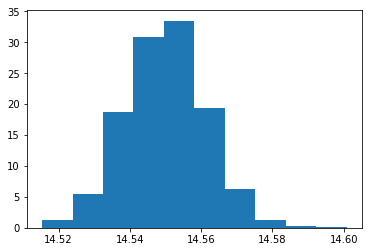

In [0]:
plt.hist(best_estimate_df['price'],bins = 10, density = True)


Text(0.5, 0, 'Mean Option Price Distribution')

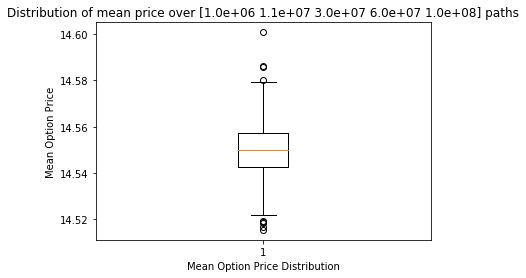

In [0]:
plt.boxplot(best_estimate_df['price'])
plt.title('Distribution of mean price over {} paths'.format(iters*paths))
plt.ylabel('Mean Option Price')
plt.xlabel('Mean Option Price Distribution')